In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D

%matplotlib inline

G = nx.Graph()
seed = 12344342 # seed for graph drawing algorithm

# Internet industry partnerships

## Introduction
Internet industry partnership is a socio-economic network available from Network Repository website (https://networkrepository.com/internet-industry-partnerships.php).

The network is a simple and undirected graph with 219 nodes and 630 edges and represents the partnerships between some unspecified companies in IT industry.

Every node represents a company and every edge represents a partnership between two companies.

Every node has a label that represents the type of products or services provided by the company: `content`, `infrastructure`, `commerce`.

Autors don't provide precise information about nodes, but we can suppose that `content` companies provide content (e.g. news, videos, music, etc.), `infrastructure` companies provide infrastructure (e.g. cloud services, hosting, hardware, etc.) and `commerce` companies are resellers of products and services provided by other companies.

The goal of this notebook is to analyze the network, find the most important companies in the network and look for patterns and communities in the network.

# Graph construction

In [3]:
with open('internet-industry-partnerships.node_labels') as node_file:
    for i,node_label in enumerate(node_file):
        G.add_node(i+1, type=int(node_label))

with open('internet-industry-partnerships.edges') as edge_file:
    for str_edge in edge_file:
        n = str_edge.split(',')
        G.add_edge(int(n[0]), int(n[1]))

print("Nodes: ", G.number_of_nodes())
print("Edges: ", G.number_of_edges())

Nodes:  219
Edges:  630


# Graph visualization

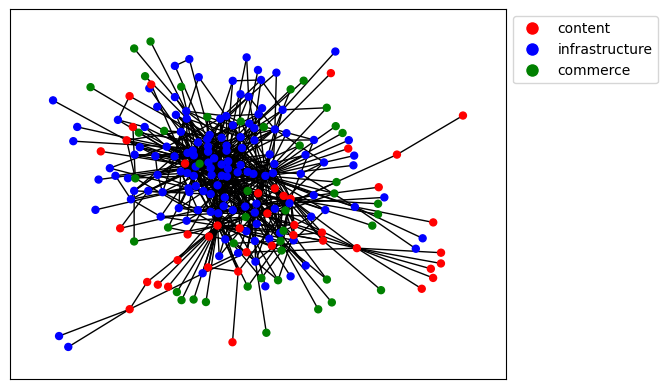

In [4]:
node_colors = [
    'red',
    'blue',
    'green'
]

labels = [
    'content',
    'infrastructure',
    'commerce'
]

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=seed),
    with_labels=False,
    node_size=25, 
    node_color=[node_colors[G.nodes[n]['type']-1] for n in G.nodes],
)

plt.legend([
    Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors[0], markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors[1], markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors[2], markersize=10)
], labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Adjacency matrix visualization

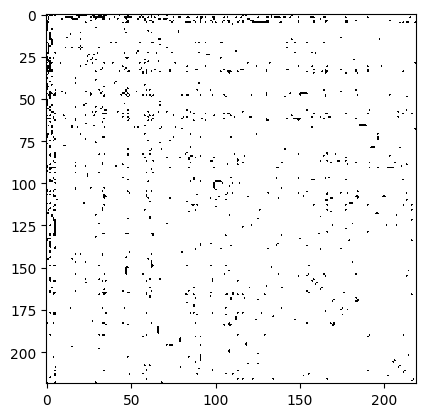

In [5]:
A = nx.adjacency_matrix(G, dtype=np.int16)
cmap = mpl.colors.ListedColormap(['white', 'black'])
plt.imshow(A.todense(), cmap=cmap)
plt.show()

### Connessione

In [6]:
if nx.is_connected(G):
    print("Graph is connected")
else:
    print("Graph is not connected")

Graph is connected


### Densità

In [7]:
m = G.number_of_edges()
n = G.number_of_nodes()

density = m / (n * (n - 1) / 2)

print("Density of the graph: ", density)

Density of the graph:  0.026391856227221313


The graph is not too dense, it could means that companies tends to not make a lot of partnerships with the other companies.

In [8]:
# Code for visualizing the graph with given centrality measure
def visualize_centrality(G, centrality, title, top=10, cmap='viridis'):
    
    print(f"Top {top} nodes by {title}:")
    for i in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top]:
        print(f"Node {i[0]}: {i[1]}")
        
    vmax = max(centrality.values())
    vmin = min(centrality.values())

    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=seed),
                    with_labels=False,
                    node_size=25,
                    node_color=[centrality[n] for n in G.nodes],
                    cmap=cmap,
                    vmin=vmin,
                    vmax=vmax
                    )
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=title, cax=plt.axes([1, 0.1, 0.03, 0.8]))
    plt.show()

### Degree centrality

Top 10 nodes by Degree Centrality:
Node 3: 0.2798165137614679
Node 1: 0.22935779816513763
Node 6: 0.2018348623853211
Node 5: 0.12844036697247707
Node 35: 0.12385321100917432
Node 2: 0.11926605504587157
Node 49: 0.11467889908256881
Node 4: 0.11009174311926606
Node 34: 0.10091743119266056
Node 63: 0.0963302752293578


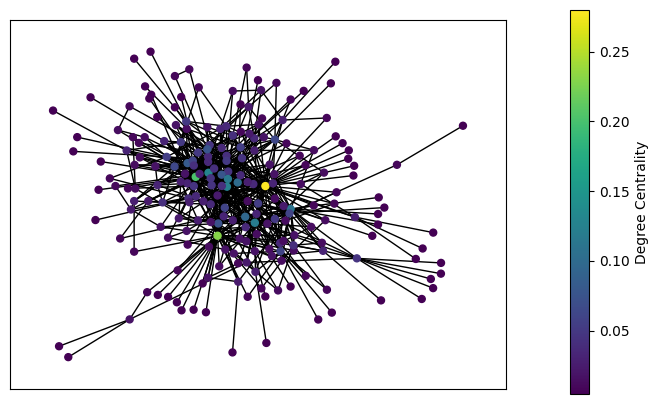

In [9]:
visualize_centrality(G, nx.degree_centrality(G), 'Degree Centrality')

### Statistics about nodes degree

In [10]:
degree_vector = A.todense() @ np.ones(A.shape[1])

print("Mean degree: ", degree_vector.mean())
print("Median degree: ", np.median(degree_vector))
print("Max degree: ", int(degree_vector.max()))
print("Min degree: ", int(degree_vector.min()))
print("Volume of the graph: ", int(degree_vector.sum()))

Mean degree:  5.7534246575342465
Median degree:  3.0
Max degree:  61
Min degree:  1
Volume of the graph:  1260


This statistics confirms the hypothesis made in density chapter.

Mean and median of nodes degrees are quite similar and small compared to the maximum value.

This is an indication of a right skewed distribution for the nodes degrees.

### Degree distribution

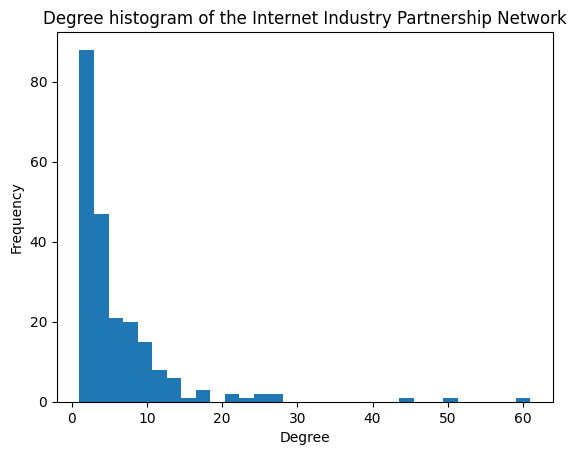

In [11]:
counts, bins, _ = plt.hist(degree_vector, bins='auto', label='Degree histogram')
bins = bins[:-1]

plt.title('Degree histogram of the Internet Industry Partnership Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [12]:
p = counts/np.sum(counts)
cdf = np.cumsum(p)
ccdf = 1 - cdf

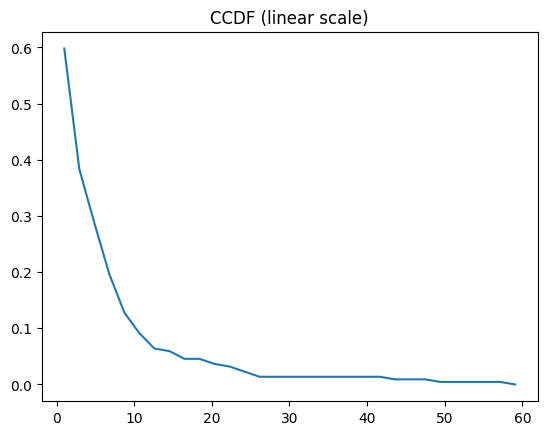

In [13]:
plt.title('CCDF (linear scale)')
_ = plt.plot(bins, ccdf, label='CCDF')

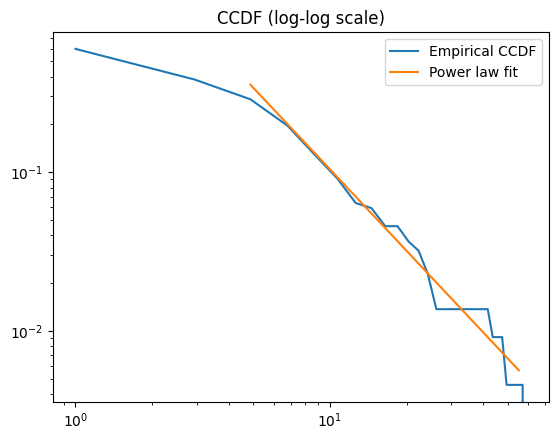

Power law exponent:  2.706712059603436
Power law threshold:  4.870967741935484


In [14]:
plt.title('CCDF (log-log scale)')

ccdf_fit = ccdf[2:-2]
bins_fit = bins[2:-2]
g = np.log(ccdf_fit[0]) - np.log(ccdf_fit[-1])
g = g / (np.log(bins_fit[0]) - np.log(bins_fit[-1]))
power_law = 5.3 * bins_fit ** g

_ = plt.loglog(bins, ccdf, label = 'Empirical CCDF')
plt.plot(bins_fit, power_law, label='Power law fit')
plt.legend()
plt.show()

print('Power law exponent: ', 1 - g)
print('Power law threshold: ', bins_fit[0])

### Closeness centrality

Top 10 nodes by Closeness Centrality:
Node 3: 0.5023041474654378
Node 1: 0.4954545454545455
Node 6: 0.48123620309050774
Node 2: 0.4678111587982833
Node 35: 0.4668094218415418
Node 49: 0.45228215767634855
Node 92: 0.448559670781893
Node 34: 0.4439918533604888
Node 48: 0.4404040404040404
Node 63: 0.43951612903225806


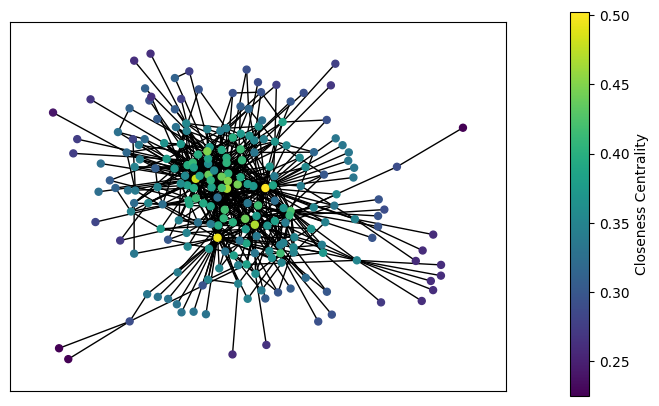

In [15]:
visualize_centrality(G, nx.closeness_centrality(G), 'Closeness Centrality')

### Statistics about distances between nodes

In [16]:
mean_distances = [1/d for d in nx.closeness_centrality(G).values()]
print("Mean geodetic distance: ", np.mean(mean_distances))
print("Diameter:", nx.diameter(G))

Mean geodetic distance:  2.982195970005446
Diameter: 6


The network seems to follow the *six degree of separation effect* (the mean geodetic distance is very short and the maximum geodetic distance is equal to 6)

### Betweenness centrality

Top 10 nodes by Betweenness Centrality:
Node 3: 0.26236060669026445
Node 1: 0.21389470769226282
Node 6: 0.16054234320146865
Node 2: 0.08934085501598367
Node 4: 0.08009538495097014
Node 35: 0.06418692037239948
Node 5: 0.05562523742241552
Node 92: 0.05080996351026971
Node 67: 0.04682847755911728
Node 63: 0.04235363326585653


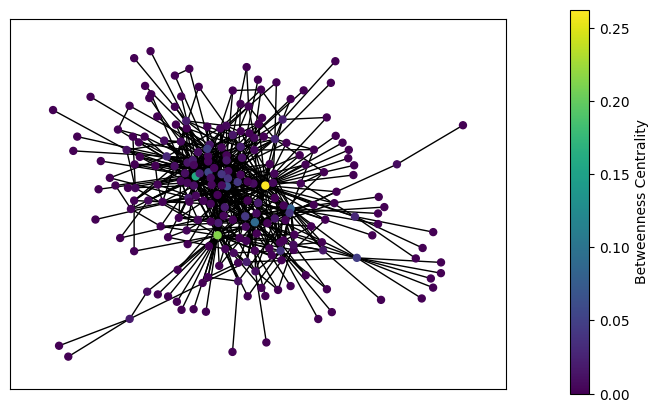

In [17]:
visualize_centrality(G, nx.betweenness_centrality(G), 'Betweenness Centrality')

### Triangles

Top 10 nodes by Triangles:
Node 3: 79
Node 1: 60
Node 6: 52
Node 49: 52
Node 35: 51
Node 2: 37
Node 5: 33
Node 60: 30
Node 63: 29
Node 34: 22


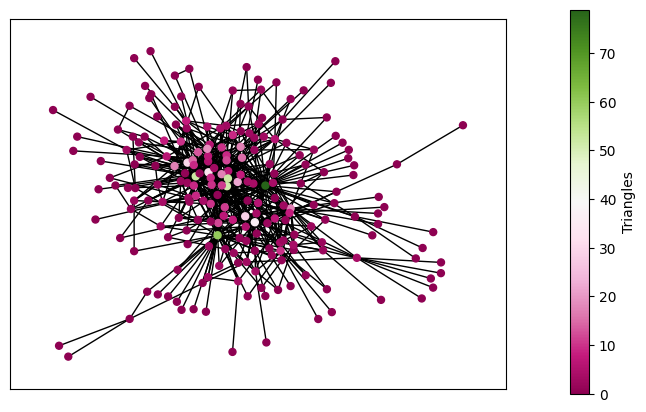

Total number of triangles in graph: 328


In [18]:
from numpy.linalg import matrix_power

visualize_centrality(G, nx.triangles(G), "Triangles", cmap="PiYG")

B = matrix_power(A.todense(), 3)
triangles = np.trace(B) // 6

print("Total number of triangles in graph:", triangles)

### Clustering coefficient

Top 20 nodes by Clustering Coefficient:
Node 9: 1.0
Node 13: 1.0
Node 22: 1.0
Node 39: 1.0
Node 44: 1.0
Node 57: 1.0
Node 65: 1.0
Node 93: 1.0
Node 112: 1.0
Node 116: 1.0
Node 127: 1.0
Node 128: 1.0
Node 145: 1.0
Node 204: 0.8333333333333334
Node 19: 0.6666666666666666
Node 20: 0.6666666666666666
Node 54: 0.6666666666666666
Node 83: 0.6666666666666666
Node 121: 0.6666666666666666
Node 33: 0.5333333333333333


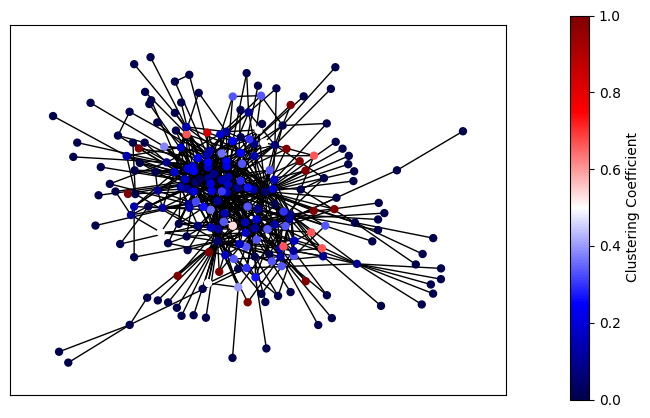

Average clustering coefficient of the graph: 0.17618253771403786


In [19]:
visualize_centrality(G, nx.clustering(G), 'Clustering Coefficient', top=20, cmap='seismic')

print("Average clustering coefficient of the graph:", nx.average_clustering(G))

The clustering coefficient of the network is not very high and it seems that nodes with high clustering coefficient are not in the "core" of the network (where all nodes have low clustering coefficients).

### Spectral ratio

In [20]:
eigvals = np.abs(np.linalg.eigvals(A.toarray()))
eigvals = np.sort(eigvals)[::-1]

print(f"Spectral ratio: {eigvals[0]}")
print(f"Second largest absolute eigenvalue: {eigvals[1]}")
print(f"Ratio: {eigvals[1]/eigvals[0]}")

Spectral ratio: 13.542925403010969
Second largest absolute eigenvalue: 8.131425301011003
Ratio: 0.6004186731474693


The power method applied to this matrix is convergent and the ratio between the firsts two eigenvalues is nearer to 1 than to 0, so the speed of convergence is slow, but not too slow.

### Katz Centrality

We define Katz centrality for undirected graph as

$$k = (\alpha A + (\alpha A)^2 + (\alpha A)^3 + \dots)\textbf{1} = (I - \alpha A)^{-1} \textbf{1}$$

for $|\alpha| < \frac{1}{\rho(A)}$. We can rewrite this as

$$ k = (I - \alpha A)^{-1} \textbf{1} \Rightarrow (I - \alpha A) k = \textbf{1} \Rightarrow k - \alpha A k = \textbf{1} \Rightarrow k = \alpha A k + \textbf{1} $$

So, we can compute Katz centrality using power iteration method.

In [21]:
# Power method. We ignore the max iteration parameter because we know that the method will converge for this matrix.
# Default parameters are set for eigenvector centrality. For Katz centrality, set alpha not equal to 1.0 and beta equal to 1.0.

def eigenvalue(A, x):
    n = A.shape[0]
    return (np.ones(n) @ (A @ x)) / (np.ones(n) @ x)

def power_method(A, alpha=1.0, beta=0.0, eps=1e-6):
    n = A.shape[0]
    k = np.ones(n)
    perronEigenvalue = eigenvalue(A, k)

    while True:
        k_new = alpha * A @ k + beta * np.ones(n)
        k_new /= np.linalg.norm(k_new, ord=np.inf) # infinity norm = max(abs(x))
        
        perronEigenvalue_new = eigenvalue(A, k_new)
        if np.abs(perronEigenvalue_new - perronEigenvalue) < eps:
            return ({i+1 : k_new[i] for i in range(n)}, perronEigenvalue_new)
        k = k_new
        perronEigenvalue = perronEigenvalue_new


Top 10 nodes by Katz centrality (power method):
Node 3: 1.0
Node 1: 0.9453930786189081
Node 6: 0.9161151191936051
Node 5: 0.8364061589946188
Node 35: 0.8346352642698999
Node 2: 0.828446567360022
Node 49: 0.8239282902001863
Node 4: 0.813701087688958
Node 34: 0.8063058509433123
Node 63: 0.8020582479577627


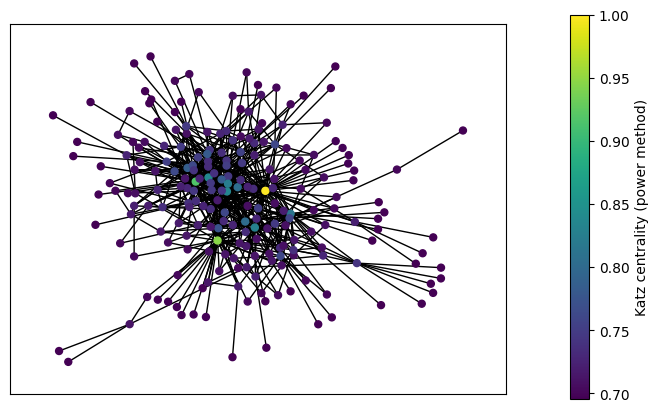

Top 10 nodes by Katz centrality (linear system):
Node 3: 1.0
Node 1: 0.9297821612870711
Node 6: 0.892532124028252
Node 5: 0.7901703341829723
Node 35: 0.7897411688027072
Node 2: 0.7809928618798452
Node 49: 0.775606277575725
Node 4: 0.7591802154551213
Node 34: 0.7513061664681479
Node 63: 0.7462712283658333


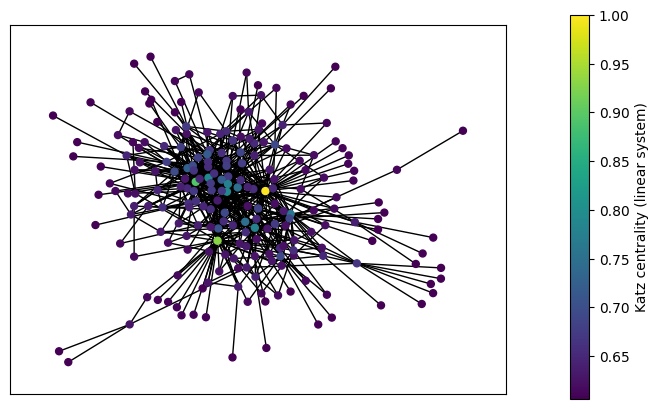

In [22]:
alpha = 0.01
katz, _ = power_method(A.todense(), alpha=alpha, beta=1.0)
visualize_centrality(G, katz, 'Katz centrality (power method)')

B = np.identity(A.shape[0]) - alpha * A.todense()
v = np.linalg.solve(B, np.ones(A.shape[0]))
v /= np.linalg.norm(v, ord=np.inf)
visualize_centrality(G, {i+1 : v[i] for i in range(A.shape[0])}, 'Katz centrality (linear system)')

### Eigenvector centrality

Top 10 nodes by Eigenvector Centrality:
Node 3: 1.0
Node 1: 0.7821840720886685
Node 6: 0.7508198172768584
Node 35: 0.6630180763151887
Node 49: 0.6471836090948923
Node 5: 0.5827435241459455
Node 2: 0.5621320405681167
Node 63: 0.4906362135878931
Node 34: 0.47555941600870233
Node 60: 0.4566192597483472


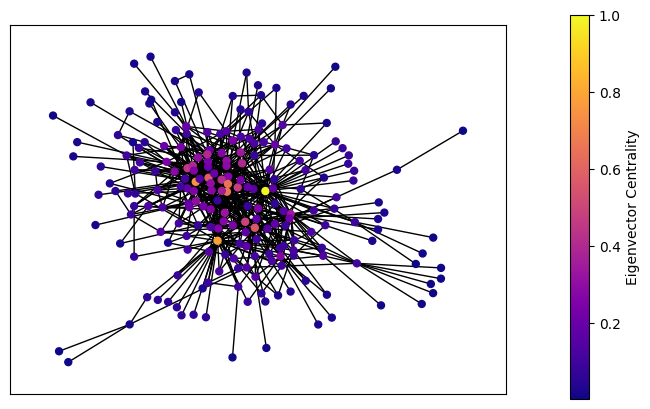

Spectral Ratio computed by power method:  13.542925772908477


In [23]:
bonacich, eigenvalue = power_method(A.todense())
visualize_centrality(G, bonacich, 'Eigenvector Centrality', cmap='plasma')
print('Spectral Ratio computed by power method: ', eigenvalue)

## Considerations about centrality indices

- The top 3 nodes are the same for all centrality indices (Node 3, node 1 and node 6).

- In general, the top 10 nodes for all centrality indices contain approximately the same nodes (see below).

- Clustering coefficient seems not correlated with others centrality (the nodes with the highest centrality are not the same as the nodes with the highest clustering coefficient).

- This could be an indication of a network with a tree-layer structure:

    - A core of very big and influent companies, with a lot of connections (in absolute terms) but not so many connections with each other (in relative terms).
        - This companies tend to make exclusive deals ("I made a deal with you, but I don't want you to make a deal with my other partner").

    - A second layer of companies with a smaller number of connections, but with a tendency to make deals with each other (and with the core companies).

    - A perifery of companies with a small number of connections.

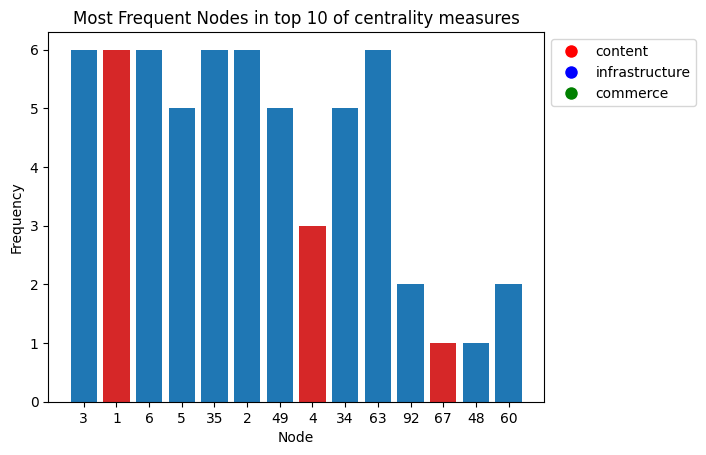

In [24]:
# We will analyze all the top 10 to discover the most frequent nodes and their characteristics

import collections

def get_top(centrality, n=10):
    return [x[0] for x in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:n]]

freq = get_top(nx.degree_centrality(G)) + \
    get_top(nx.betweenness_centrality(G)) + \
    get_top(nx.closeness_centrality(G)) + \
    get_top(bonacich) + \
    get_top(katz) + \
    get_top(nx.triangles(G))

freq = collections.Counter(freq)
names = [str(x) for x in freq.keys()]
values = list(freq.values())
colors = [f'tab:{node_colors[G.nodes[x]["type"]-1]}' for x in freq.keys()]
plt.bar(names, values, color=colors)
plt.xlabel('Node')
plt.ylabel('Frequency')
plt.title('Most Frequent Nodes in top 10 of centrality measures')
plt.legend([
    Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors[0], markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors[1], markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors[2], markersize=10)
], labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

From the graph above we can see that the most important companies that appears in top 10 of all centrality measures are prevalently infrastructure companies.

Some hypothesis of this behaviour are:

- software depends on hardware

- tendency to exclusiveness in collaborations which generates a "pseudo-star" structure (as we discussed in the previous section)

## Assortativity

In this section we will look at the assortativity of the network. For each type of nodes we will convert the network to a binary network and calculate the assortativity.

In [63]:
def type_assortativity(G: nx.Graph, node_type):
    x = []
    y = []
    for start_type, end_type in nx.node_attribute_xy(G, 'type'):
        x.append(start_type == node_type)
        y.append(end_type == node_type)
    return np.corrcoef(x, y)[0, 1]

content_assortativity = type_assortativity(G, 1)
infrastructure_assortativity = type_assortativity(G, 2)
commerce_assortativity = type_assortativity(G, 3)

print('Assortativity coefficient of content companies:', content_assortativity)
print('Assortativity coefficient of infrastructure companies:', infrastructure_assortativity)
print('Assortativity coefficient of commerce companies:', commerce_assortativity)

Assortativity coefficient of content companies: 0.2630188679245285
Assortativity coefficient of infrastructure companies: 0.33823529411764736
Assortativity coefficient of commerce companies: 0.10879629629629634


The network is non-assortative with respect to the type of the nodes.

### Degree assortativity

In [39]:
x = []
y = []
for start_degree, end_degree in nx.node_degree_xy(G):
    x.append(start_degree)
    y.append(end_degree)
print(np.corrcoef(x,y)[0,1])

-0.21683627051421017


## Meso-scale analysis

### K-cores

### Community detection

## Comparison with random generated networks